## PACKAGES AND LIBRARIES

In [ ]:
!pip install librosa --upgrade

# DATASET

In [2]:
mypath = r"C:\Users\acer\Downloads\ICBHI\Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 

In [3]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

In [4]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [5]:
p_diag = pd.read_csv(r"C:\Users\acer\Downloads\ICBHI\Respiratory_Sound_Database\Respiratory_Sound_Database\patient_diagnosis.csv",header=None) # patient diagnosis file

In [6]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files


# DATA AUGMENTATION FUNCTIONS

NOISE

In [7]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    return data

STRETCH

In [8]:
def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

PITCH

In [9]:
def pitch_process(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# DATA PROCESS FUNCTIONS

EXTRACT FEATURES

In [10]:
def extract_process(data, sample_rate):
    output_result = np.array([])

    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))

    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))

    return output_result

EXPORT FEATURES

In [11]:
def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it,
    and extracts several audio features including mean values of MFCC, Zero Crossing Rate,
    Chromagram, Root Mean Square Energy, and Mel Spectrogram from the original and its augmented versions.
    """
    try:
        # Load the original audio file
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=42, offset=0.6)

        # Extract features from the original audio data
        extracted_features = extract_process(audio, sample_rate)
        result = np.array(extracted_features)

        # Add noise and extract features
        noise_out = add_noise(audio)
        output_2 = extract_process(noise_out, sample_rate)
        result = np.vstack((result, output_2))

        # Time-stretch and then pitch-shift before extracting features
        new_out = stretch_process(audio,0.8)
        stretch_pitch = pitch_process(new_out, sample_rate,pitch_factor=0.7)
        output_3 = extract_process(stretch_pitch, sample_rate)
        result = np.vstack((result, output_3))

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print("Error Details:", e)
        return None

    return result

# DATA PROCESS AND ENGINEERING

TRANSFORMATION AND EXPORTATION

In [12]:
features = []

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

C:\Users\acer\anaconda3\envs\myenv\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Finished feature extraction from  920  files


In [13]:
features.shape

(920, 3, 182)

In [14]:
# delete the very rare diseases
new_features = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

new_labels = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [15]:
# print class counts
unique_elements, counts_elements = np.unique(new_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


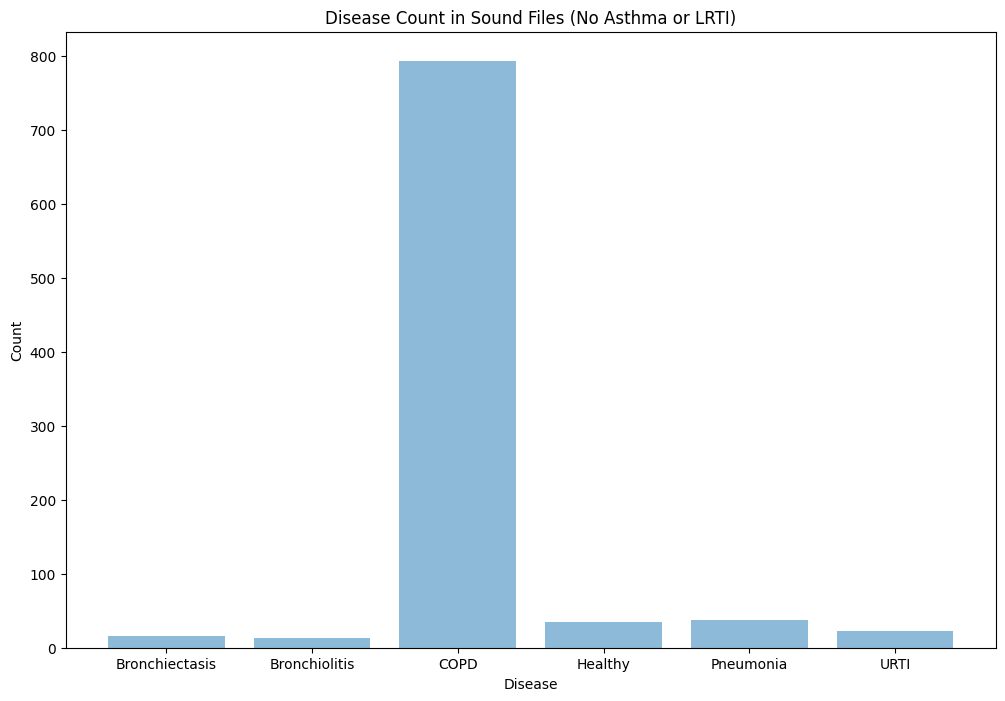

In [17]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

Flattened features array for preapering 1D CNN Model

In [18]:
flattened_features = new_features.reshape(-1, 182)


In [19]:
augmented_labels = np.repeat(labels, 3)

In [20]:
augmented_features = np.reshape(features, (-1, 182))  # Flatten the feature sets

mask = ~np.isin(augmented_labels, ['Asthma', 'LRTI'])
augmented_features = augmented_features[mask]
augmented_labels = augmented_labels[mask]

In [21]:
le = LabelEncoder()
i_labels = le.fit_transform(augmented_labels)
oh_labels = to_categorical(i_labels)

In [22]:
oh_labels.shape

(2751, 6)

In [23]:
flattened_features.shape

(2751, 182)

In [24]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(flattened_features, oh_labels, stratify=oh_labels,
                                                    test_size=0.2, random_state = 42)

In [25]:
#SCALER & TRANSFORMATION
scaler_data = StandardScaler()

In [26]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2200, 182)
(2200, 6)
(551, 182)
(551, 6)


In [27]:
x_train = scaler_data.fit_transform(x_train)
x_test = scaler_data.transform(x_test)

In [28]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)

# 1D CNN Model

In [29]:
from tensorflow.keras import layers, Sequential

num_labels = len(np.unique(new_labels))  # Determine the number of unique classes

Model = Sequential([
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=num_labels, activation='softmax')
])

C:\Users\acer\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 182, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 91, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 91, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 46, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 46, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 23, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 12, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,110 (2.10 MB)

 Trainable params: 551,110 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])


In [34]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

In [35]:
evConv1D_Model = Model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 201ms/step - accuracy: 0.7633 - loss: 0.9816 - val_accuracy: 0.8639 - val_loss: 0.5943
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.8696 - loss: 0.6211 - val_accuracy: 0.8639 - val_loss: 0.5450
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.8567 - loss: 0.6043 - val_accuracy: 0.8639 - val_loss: 0.5525
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.8761 - loss: 0.4913 - val_accuracy: 0.8639 - val_loss: 0.4540
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.8594 - loss: 0.4920 - val_accuracy: 0.8657 - val_loss: 0.4268
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.8742 - loss: 0.4329 - val_accuracy: 0.8675 - val_loss: 0.4046
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.8821 - loss: 0.3900 - val_accuracy: 0.8639 - val_loss: 0.4021
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.8789 - loss: 0.3551 - val_acc

In [36]:
Model_Results = Model.evaluate(x_test,y_test)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8949 - loss: 0.3767
LOSS:  0.3508
ACCURACY:  0.8984


Plotting Train and Validation Loss & Accuracy:

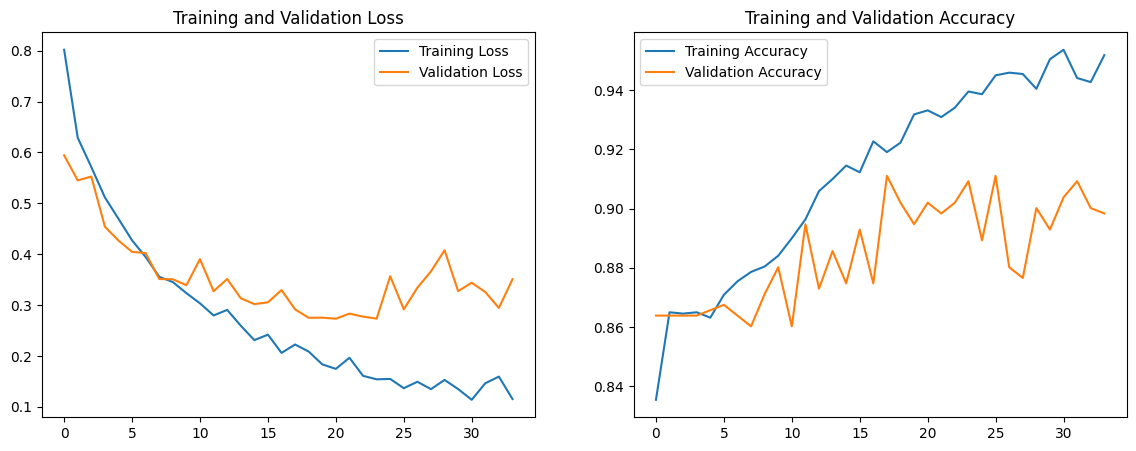

In [37]:

# Plotting loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(evConv1D_Model.history['loss'], label='Training Loss')
plt.plot(evConv1D_Model.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(evConv1D_Model.history['accuracy'], label='Training Accuracy')
plt.plot(evConv1D_Model.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


Confusion Matrix:

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


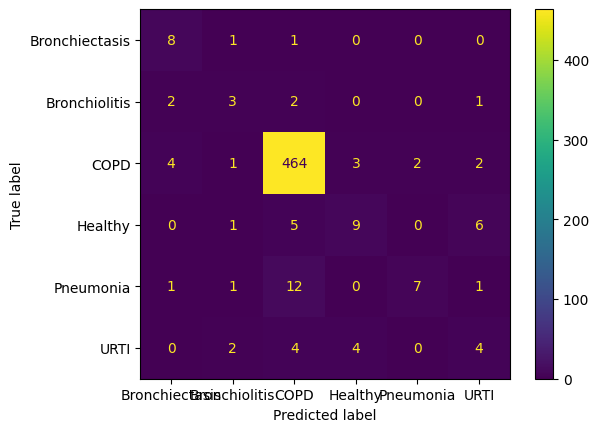

In [38]:
# Getting the predictions
y_pred = Model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generating the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Displaying the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()